In [2]:
def get_xy_mesh(size, r=3.0**0.5):
    r = r[0]
    ratio = size[0] / size[1]
    rng0 = torch.linspace(-r * ratio, r * ratio, size[0])
    rng1 = torch.linspace(-r, r, size[1])
    xy = torch.stack([*torch.meshgrid(rng0, rng1)], -1).float()  # noqa
    xy = torch.unsqueeze(xy, 0).permute(0, 3, 1, 2)
    return xy

In [49]:
import torch

size_tensor = torch.LongTensor([10, 10])
r = torch.FloatTensor([1.0])

class FakeModule(torch.nn.Module):
    def __init__(self):
        super(FakeModule, self).__init__()
        self.f = torch.jit.trace(get_xy_mesh, (size_tensor, r))
        self.f = get_xy_mesh
    def forward(self, size_tensor, r):
        return self.f(size_tensor, r)
    
torch.jit.save(
    torch.jit.trace(FakeModule(), (size_tensor, r)),
    f='/home/liam/get_xy_mesh_trace.pth'
)

m = torch.jit.load('/home/liam/get_xy_mesh_trace.pth')

/home/liam/dreamz/src/dreamz/cppn.py:12: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if size[0] >= size[1]:


TypeError: linspace(): argument 'start' (position 1) must be Number, not Tensor

In [50]:
m(size_tensor, r).shape

torch.Size([1, 2, 10, 10])

In [70]:
mm = torch.jit.load('/home/liam/cppn_trace.pth').cpu()

In [77]:
im = mm(m(torch.LongTensor([100, 100]), torch.FloatTensor([3.0 ** .5])))

In [78]:
im.shape

torch.Size([1, 392, 392, 3])

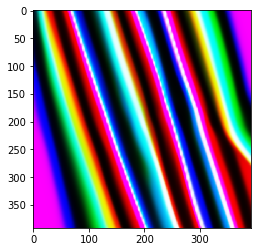

In [79]:
import pylab as plt
plt.imshow(im[0].detach().cpu().numpy())

In [26]:
xy = m(size_tensor, r)

In [27]:
from dreamz.cppn import *

class CPPNNet(nn.Module):
    def __init__(
            self,
            n_channels_list,
            kernel_size=1,
            act_fn=composite_activation,
            use_bn=False,
            input_channels=2,
            output_channels=4):

        super(CPPNNet, self).__init__()
        self.use_bn = use_bn
        self.layers = []
        self.input_channels = input_channels
        self.output_channels = output_channels
        n_channels_list = [input_channels] + n_channels_list + [output_channels]
        chans0 = n_channels_list[0]
        for i, chans1 in enumerate(n_channels_list[1:]):
            this = nn.Sequential()
            if self.use_bn:
                this.add_module('bn{}'.format(i), nn.BatchNorm2d(chans0))
            this.add_module('conv{}'.format(i), nn.Conv2d(chans0, chans1, kernel_size))
            # Initialise the weight to preserve mean/std
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (chans0 * (kernel_size ** 2)))
            )
            if i < len(n_channels_list) - 2:
                this.add_module('act{}'.format(i), Lambda(act_fn))
                chans0 = chans1 * 2
            self.layers.append(this)
        self.layers = nn.Sequential(*self.layers)
        self.final_act = nn.Sigmoid()

    def do_debug_prints(self):
        print('weight', self.layers[-2][0].weight.mean().item())
        print('grad', torch.abs(self.layers[-2][0].weight.grad).mean())

    def forward(self, x, debug=False):
        if debug:
            for fc in self.layers:
                x = fc(x)
                print(x.view(- 1).mean(), x.view(-1).std())
        else:
            x = self.layers(x)
        x = self.final_act(x)
        return x.permute(0, 3, 2, 1)

cppn = CPPNNet([13] * 5)
cppn(xy).shape
cppn_trace = torch.jit.trace(cppn, xy)
torch.jit.save(cppn_trace, '/home/liam/cppn_trace.pth')

In [81]:
from dreamz.cppn import *

class CPPNNet(nn.Module):
    def __init__(
            self,
            n_channels_list,
            kernel_size=1,
            act_fn=composite_activation,
            use_bn=False,
            input_channels=2,
            output_channels=4):

        super(CPPNNet, self).__init__()
        self.use_bn = use_bn
        self.layers = []
        self.input_channels = input_channels
        self.output_channels = output_channels
        n_channels_list = [input_channels] + n_channels_list + [output_channels]
        chans0 = n_channels_list[0]
        for i, chans1 in enumerate(n_channels_list[1:]):
            this = nn.Sequential()
            if self.use_bn:
                this.add_module('bn{}'.format(i), nn.BatchNorm2d(chans0))
            this.add_module('conv{}'.format(i), nn.Conv2d(chans0, chans1, kernel_size))
            # Initialise the weight to preserve mean/std
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (chans0 * (kernel_size ** 2)))
            )
            if i < len(n_channels_list) - 2:
                this.add_module('act{}'.format(i), Lambda(act_fn))
                chans0 = chans1 * 2
            self.layers.append(this)
        self.layers = nn.Sequential(*self.layers)
        self.final_act = nn.Sigmoid()

    def do_debug_prints(self):
        print('weight', self.layers[-2][0].weight.mean().item())
        print('grad', torch.abs(self.layers[-2][0].weight.grad).mean())

    def forward(self, x, o, debug=False):
        other = o.unsqueeze(1).unsqueeze(1).unsqueeze(0).repeat([1, 1, x.size(2), x.size(3)])
        x = torch.cat([x, other], 1)
        if debug:
            for fc in self.layers:
                x = fc(x)
                print(x.view(- 1).mean(), x.view(-1).std())
        else:
            x = self.layers(x)
        x = self.final_act(x)
        return x.permute(0, 3, 2, 1)

cppn = CPPNNet([5] * 20, input_channels=4)
o = torch.zeros([2])
print(cppn(xy, o).shape)
cppn_trace = torch.jit.trace(cppn, (xy, o))
torch.jit.save(cppn_trace, '/home/liam/cppn_trace.pth')

torch.Size([1, 10, 10, 4])


In [13]:
size_tensor = torch.LongTensor([600, 600])
r = torch.FloatTensor([1.0])
xy = m(size_tensor, r)

In [19]:
cppn = cppn.cuda()

In [20]:
xy = xy.cuda()

In [31]:
import time


In [72]:
now = time.time()
with torch.no_grad():
    for i in range(25):
        cppn(xy).cpu().numpy().shape
print(time.time() - now)

0.6060454845428467
